In [1]:
## PyTorch doesn't fully support MPS devices yet (as of Feb 5, 2024)
## See: https://github.com/pytorch/pytorch/issues/77764#
## The following allows PyTorch to fall back to the CPU whenever it
## encounters an unsupported operation
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [4]:
from PIL import Image    ## Image tools
import torch
import torch.nn as nn
from torchvision import models    ## Pretrained models
from torchvision import transforms    ## Transforms

In [5]:
## Copy the classes from:
## https://github.com/deep-learning-with-pytorch/dlwpt-code/blob/master/p1ch2/3_cyclegan.ipynb
## so I can play along...

class ResNetBlock(nn.Module): # <1>

    def __init__(self, dim):
        super(ResNetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x) # <2>
        return out


class ResNetGenerator(nn.Module):

    def __init__(self, input_nc=3, output_nc=3, ngf=64, n_blocks=9): # <3> 

        assert(n_blocks >= 0)
        super(ResNetGenerator, self).__init__()

        self.input_nc = input_nc
        self.output_nc = output_nc
        self.ngf = ngf

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=True),
                 nn.InstanceNorm2d(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2**i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3,
                                stride=2, padding=1, bias=True),
                      nn.InstanceNorm2d(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2**n_downsampling
        for i in range(n_blocks):
            model += [ResNetBlock(ngf * mult)]

        for i in range(n_downsampling):
            mult = 2**(n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=True),
                      nn.InstanceNorm2d(int(ngf * mult / 2)),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input): # <3>
        return self.model(input)


In [6]:
## Instatiate a ResNetGenerator
netG = ResNetGenerator()

In [7]:
## Load parameters from pretraining on horse2zebra dataset
model_path = "../torch_pretrained_vision/practice_data/horse2zebra_0.4.0.pth"
model_data = torch.load(model_path)
netG.load_state_dict(model_data)

<All keys matched successfully>

In [8]:
## Put the model into evaluation mode
netG.eval()

ResNetGenerator(
  (model): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (9): ReLU(inplace=True)
    (10): ResNetBlock(
      (conv_block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (3): ReLU(inplace=True)
        (4): ReflectionPad2d((1, 1, 1, 1))
     

In [10]:
## Define a preprocessor for new inputs so they can be fed to the model
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor()])

## Grab some pictures of horses to play with
img = Image.open("../torch_pretrained_vision/practice_data/horse.jpg")
img_b = Image.open("../torch_pretrained_vision/practice_data/another_horse.jpg")

## Get them ready for the model
## Transform
imt_t = preprocess(img)
imt_t_b = preprocess(img_b)
## Batch
batch_t = torch.unsqueeze(imt_t,0)
batch_t_b = torch.unsqueeze(imt_t_b,0)

In [13]:
## Get the output
batch_out = netG(batch_t)
batch_out_b = netG(batch_t_b)

## Convert to images
out_t = (batch_out.data.squeeze() + 1.0)/2.0
out_t_b = (batch_out_b.data.squeeze() + 1.0)/2.0

out_img = transforms.ToPILImage()(out_t)
out_img_b = transforms.ToPILImage()(out_t_b)

## Save them for fun
out_img.save("../torch_pretrained_vision/practice_data/horse2zebra.jpg")
out_img_b.save("../torch_pretrained_vision/practice_data/horse2zebra_b.jpg")

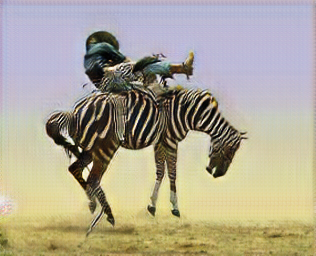

In [12]:
out_img

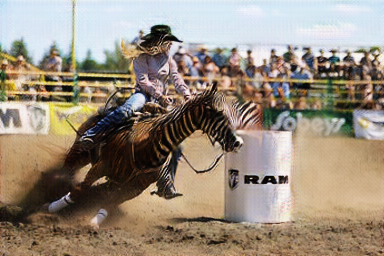

In [14]:
out_img_b